In [1]:
# Data Analysis of Beijing Taxi Trajectories

# We are given GPS and time data for approximately 10k taxis that traveled their normal routes during 
# February 2-8, 2008.  Here is the data the Microsoft Research team found re: their analysis:
# - 10,357 taxis
# - 15M lines of data, where a line comprises GPS coordinate pairs and time info
# - 9M kilometers of road traveled
# - 177 secs or nearly 3 mins on average for 'sampling time' across all taxis
# - 623 meters average distance traveled between 'snapshots' of all taxis' locations from GPS measurements

# Here's a quick table to compare Microsoft Research team results and my results: 
#                                |  Microsoft    |  My Analysis                                       |
#                                |_______________|____________________________________________________|
#   | Lines of data              |     15M       |    17.7M rows initially; 14.3M after preprocessing |
#   | Road traveled (km)         |      9M       |    10.4M                                           |
#   | Avg distance interval (m)  |     623       |     731                                            |
#   | Avg time interval (sec)    |     177       |     186                                            |

# Note that the sampling frequency of these taxi trajectories can be used to determine traffic hotspots at 
# any given time within the City, as well as see preferred traffic paths through the City.

# The original Microsoft Research white paper can be found at:
#    www.microsoft.com/en-us/research/publication/t-drive-trajectory-data-sample

# We are asked to cite the following papers when using taxi dataset:
# [1] Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun, "Driving With Knowledge from the Physical World," 2011
# [2] Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xei, Xing Xie, Guangzhong Sun, and Yan Huang, "T-Drive:  Driving 
#     Directions Based On Taxi Trajectories," 2010

In [ ]:
# Files for all 10,357 taxis can be found in MasterCompleteDataSet.zip at:
#    https://drive.google.com/open?id=0B7HB0g6q7bfuTGhUeDF3REdIR1E

In [2]:
# Import needed packages for this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import datetime as datetime

In [3]:
# Place unzipped folder with data for 10k+ taxis in path used locally; use glob to capture all files

path = r'/Users/christine/Desktop/MasterCompleteDataSet'
all_files = glob.glob(os.path.join(path, "*.txt"))   

In [4]:
# Construct dataframe

df = []
colnames = ['taxi_id', 'date_time', 'longitude', 'latitude']

for f in all_files:
    df.append(pd.read_csv(f,
                         header=None,
                         infer_datetime_format=True,
                         names=colnames))
df = pd.concat(df, ignore_index=True)  

In [5]:
# Ensure proper time data type

df['date_time'] = pd.to_datetime(df.date_time) 

In [6]:
df.dtypes

taxi_id             float64
date_time    datetime64[ns]
longitude           float64
latitude            float64
dtype: object

In [7]:
# Size of initial dataframe

message = "{:,} rows in initial dataframe"
print(message.format(len(df)))

17,662,984 rows in initial dataframe


In [8]:
# Preprocess data - Check -- and then drop -- duplicates in dataframe 

df.drop_duplicates(inplace=True)
df.shape

(16325487, 4)

In [9]:
# Preprocess data - Check for NAN's in dataframe

df.dropna().shape
df.shape

(16325487, 4)

In [10]:
# Preprocess data - Do quick check to ensure data represented in dataframe comprises only those 7 days
# from Feb 2 to Feb 8 in 2008

timelow = pd.to_datetime('2/2/2008')
timehigh = pd.to_datetime('2/9/2008')
df = df.loc[((df.date_time >= timelow) & (df.date_time < timehigh)), :]
df.shape

(16325487, 4)

In [11]:
# Preprocess data - Do quick check on any outliers in GPS <lat, long> that are outside of 'bounding box'
# that represents Beijing.  Start with latitude.

latlow = 39.65
lathigh = 40.20
df = df.loc[((df.latitude >= latlow) & (df.latitude <= lathigh)), :]
df.shape

(15227603, 4)

In [12]:
# Preprocess data - Check now for longitudinal outliers

longlow = 116.15
longhigh = 116.90
df = df.loc[((df.longitude >= longlow) & (df.longitude <= longhigh)), :]
df.shape

(14262198, 4)

In [13]:
# Size of dataframe after all outlier checks

message1 = "{:,} rows in dataframe after all preprocessing"
print(message1.format(len(df)))

14,262,198 rows in dataframe after all preprocessing


In [14]:
# Time intervals (or sampling frequency) - Find the deltas between the times

grouped = df.sort_values(by='date_time').groupby('taxi_id')['date_time']

samples = []

for g, times in grouped:
    samples.append(times.diff().astype('timedelta64[m]'))
    
samples = pd.concat(samples)
samples.dropna(inplace=True)

In [15]:
samples.shape

(14251933,)

In [16]:
samples.head()

1    10.0
3    10.0
4    10.0
5    10.0
6    10.0
Name: date_time, dtype: float64

In [17]:
samples.tail()

490220    5.0
490221    5.0
490222    5.0
490223    4.0
490224    5.0
Name: date_time, dtype: float64

In [18]:
samples.min()

0.0

In [19]:
samples.max()

8600.0

In [20]:
# Okay, above max of 8600 mins or nearly 6 days is way yuuuge(!) 
# Need to do sanity check on these time intervals or how often taxi's location is recorded
# Assume outliers are anything over 30 mins, so we will only consider values in our mean calculation if
# 30 mins or under

# We find below the result is a little above 3 mins (or precisely 186 secs), whereas Microsoft Research had a 
# result of 177 secs 

message2 = "{:,.2f} minutes is the average sampling frequency (or time interval)"
print(message2.format(samples[samples <= 30].mean()))

3.10 minutes is the average sampling frequency (or time interval)


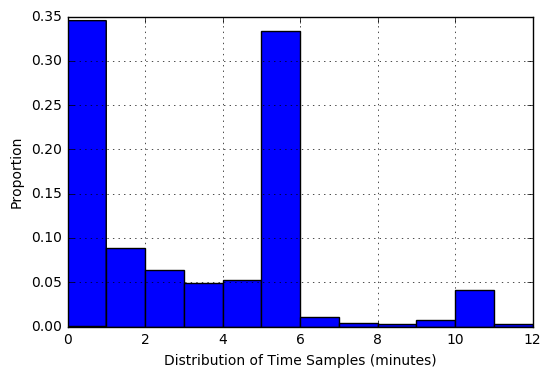

In [21]:
# We are asked to generate the plots shown in the Microsoft Research white paper.  Below is the plot of
# distribution of time samples across all taxis.

time_hist = samples.hist(normed=True, range=(0,12), bins=12)
time_hist.set_ylabel("Proportion")
time_hist.set_xlabel("Distribution of Time Samples (minutes)")
plt.show()

In [22]:
# Distance intervals
# Function to calculate distance using Haversine formula for GPS coordinate pairs in millions of rows of data
# This is my modification to speedy Haversine calculation found at Stack Overflow #29545704

def FastHaversine(lat, long):
    
    lat = np.array(lat)
    long = np.array(long)
    lat1 = lat[0:-1]
    lat2 = lat[1:]
    long1 = long[0:-1]
    long2 = long[1:]
    lat1, long1, lat2, long2 = map(np.radians, [lat1, long1, lat2, long2])
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = 1000 * 6371 * c
    
    return meters

In [23]:
# Distance intervals - This calculates the differences between the GPS coordinate pairs

grouped = df.sort_values(by='date_time').groupby('taxi_id')

distances = []

for g in grouped:
    distances.append(pd.DataFrame(FastHaversine(g[1].latitude.values, g[1].longitude.values)))
    
distances = pd.concat(distances)
distances.dropna(inplace=True)

In [24]:
distances.head()

,0
0,1957.284990
1,3195.604390
2,3795.225678
3,1390.187985
4,1979.535000


In [25]:
distances.tail()

,0
479,4113.034214
480,3395.351739
481,3064.452418
482,511.009685
483,7.586082


In [26]:
distances.min()

0    0.0
dtype: float64

In [27]:
distances.max()

0    73647.024178
dtype: float64

In [28]:
# So 73.6 kms is again totally yuuuge
# In keeping with time interval outlier check, where anything over 30 mins was discarded...
# ...Here on distance portion, an outlier will be considered any value over 25km
# The reasoning is that a taxi can likely travel at most at 50 km (or 30 miles) through congested city 
# in one hour (or 2 * 30 mins)

# Our result below is just over 10M kms or 10.41 x 10^6 km, whereas Microsoft Research's result was 9M kms

print("Total kilometers traveled by all taxis: ", ((distances[distances<=25000] / 1000).sum()))

Total kilometers traveled by all taxis:  0    1.041433e+07
dtype: float64


In [29]:
# So average distance traveled between GPS recordings is 731 meters
# The Microsoft Research found an average distance interval of 623 meters

print("Average distance interval across all taxis: ", (distances[distances <= 25000].mean()))

Average distance interval across all taxis:  0    731.151081
dtype: float64


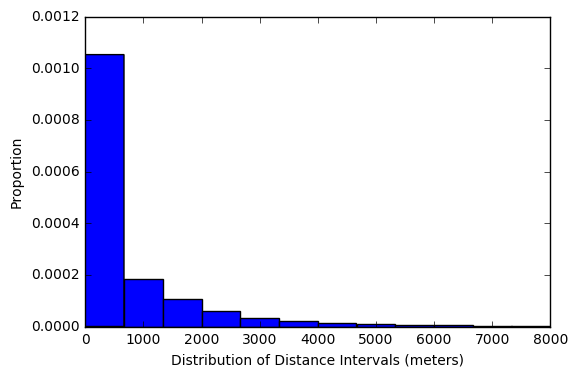

In [30]:
# We are asked to generate the plots shown in the Microsoft Research white paper.  Plot below shows the 
# distribution of distance intervals among all of the taxis.

fig = plt.figure()
n, bins, patches = plt.hist(distances, normed=True, range=(0,8000), bins=12)
plt.ylabel("Proportion")
plt.xlabel("Distribution of Distance Intervals (meters)")
plt.show()